In [62]:
import random
import sys
from collections import defaultdict
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Ensure outer package root on path so flattened single-level imports work
proj_root = Path.cwd()
outer_pkg_root = proj_root / "intrinsic_camera_calibrator"
if str(outer_pkg_root) not in sys.path:
    sys.path.append(str(outer_pkg_root))

# Single-level imports (flattened via outer __init__.py)

# Indices for cameras
LEFT, RIGHT = 0, 1

# Unified container for per‑camera data (flattened)
cam = {
    "objpoints": [[], []],  # 3D object points per camera
    "imgpoints": [[], []],  # 2D image points per camera
    "image_indices": [[], []],  # image index per detected board (for single-shot filtering)
    "K": [None, None],
    "dist": [None, None],
    "R": [None, None],  # rectification rotations
    "P": [None, None],  # projection matrices
    "map1": [None, None],  # rectification map x
    "map2": [None, None],  # rectification map y
}


In [63]:
# Prefer pathlib.glob and handle notebooks where __file__ may be undefined
base = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent
raw_data_folder = base / "data" / "34759_final_project_raw"

images_left = sorted((raw_data_folder / "calib" / "image_02" / "data").glob("*.png"))
images_right = sorted((raw_data_folder / "calib" / "image_03" / "data").glob("*.png"))
# images_left = sorted((raw_data_folder / "calib" / "image_02" / "data").glob("*00.png"))
# images_right = sorted((raw_data_folder / "calib" / "image_03" / "data").glob("*00.png"))

# convert to strings for cv2.imread if needed
images_left = [str(p) for p in images_left]
images_right = [str(p) for p in images_right]

assert len(images_left) and len(images_right), "Missing calibration images for one or both cameras"

# Chessboard corners

In [64]:
def find_all_chessboards(gray, pattern_sizes, max_boards=10):
    all_corners = []
    all_objp = []
    all_pattern_sizes = []
    work = gray.copy()
    flags_normal = (
        cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE | cv2.CALIB_CB_FAST_CHECK
        # | cv2.CALIB_CB_FILTER_QUADS
    )
    flags_SB = (
        cv2.CALIB_CB_EXHAUSTIVE | cv2.CALIB_CB_NORMALIZE_IMAGE | cv2.CALIB_CB_ACCURACY
        # cv2.CALIB_CB_LARGER
    )
    # Use SB variant if available for robustness:
    # use_sb = hasattr(cv2, "findChessboardCornersSB")
    # use_sb = False
    avg_color = np.average(gray)

    # Note: pattern_sizes should be an ordered iterable (list/tuple), not a set, for reproducibility
    for nb_vert, nb_horiz in pattern_sizes:
        for _ in range(max_boards):
            ret, corners = cv2.findChessboardCornersSB(work, (nb_vert, nb_horiz), flags=flags_SB)
            use_sb = True
            if not ret:
                ret, corners = cv2.findChessboardCorners(work, (nb_vert, nb_horiz), flags=flags_normal)
                use_sb = False

            if not ret:
                break

            # prepare object points: (x, y, 0) grid
            objp = np.zeros((nb_horiz * nb_vert, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nb_vert, 0:nb_horiz].T.reshape(-1, 2)
            all_objp.append(objp)
            all_pattern_sizes.append((nb_vert, nb_horiz))

            # Subpixel refine on original gray only if not using SB (SB is already subpixel-accurate)
            if use_sb:
                # Ensure float32 shape for downstream consumers
                corners_ref = corners.astype(np.float32, copy=False)
            else:
                # Ensure correct dtype and contiguous layout
                corners = corners.astype(np.float32, copy=False)
                # Determine a reasonable subpixel window from the detected board bbox
                x, y, w, h = cv2.boundingRect(corners)
                # Estimate checker square size (in pixels) along both axes
                sq_w = max(1.0, w / max(1, (nb_vert - 1)))
                sq_h = max(1.0, h / max(1, (nb_horiz - 1)))
                # Pick a conservative window ~ 1/4 square size, clamped
                auto_win = int(max(3, min(15, 0.25 * min(sq_w, sq_h))))
                win = (auto_win, auto_win)
                # Termination criteria
                term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
                # cornerSubPix modifies the array in-place in many OpenCV builds
                corners = cv2.cornerSubPix(gray, corners, win, (-1, -1), term)
                corners_ref = corners

            all_corners.append(corners_ref)

            # Mask out detected board region (expand a bit) to find the next one
            x, y, w, h = cv2.boundingRect(corners_ref)
            pad = 10
            x0, y0 = max(0, x - pad), max(0, y - pad)
            x1, y1 = min(work.shape[1], x + w + pad), min(work.shape[0], y + h + pad)
            cv2.rectangle(work, (x0, y0), (x1, y1), color=avg_color, thickness=-1)

    return all_corners, all_objp, all_pattern_sizes

In [65]:
pattern_sizes = [(11, 7), (15, 5), (7, 5)]  # (nb of vert pnts, nb of horiz pnts)

# Criteria for corner refinement
criteria = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 100, 0.001)

for idx, image_list in enumerate([images_left, images_right]):
    for img_idx, fname in enumerate(image_list):
        img = cv2.imread(fname)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        corners_sets, objp_list, pattern_sizes_list = find_all_chessboards(gray, pattern_sizes)

        for corners, objp, (nb_vertical, nb_horizontal) in zip(
            corners_sets, objp_list, pattern_sizes_list, strict=False
        ):
            cam["imgpoints"][idx].append(corners)
            cam["objpoints"][idx].append(objp)
            cam["image_indices"][idx].append(img_idx)  # record image index for this board
#             vis = cv2.drawChessboardCorners(img.copy(), (nb_vertical, nb_horizontal), corners, True)
#             cv2.imshow("Corners", vis)
#             cv2.waitKey(0)

# cv2.destroyAllWindows()

In [66]:
nb_imgp = []
nb_objp = []
for i in range(len(cam["imgpoints"])):
    nb_imgp.append(len(cam["imgpoints"][i]))
    nb_objp.append(len(cam["objpoints"][i]))

nb_imgp, nb_objp

([247, 208], [247, 208])

In [6]:
indexes = np.arange(nb_imgp[0])
rnd_Gen = np.random.default_rng()
rnd_Gen.shuffle(indexes)
indexes[:100]

array([ 8,  0, 10,  3,  7, 11,  1,  5,  4, 12,  9,  6,  2])

In [7]:
indexes[:10]

array([ 8,  0, 10,  3,  7, 11,  1,  5,  4, 12])

In [8]:
# objp_subset = [cam["objpoints"][LEFT][i] for i in indexes[:50]]
# imgp_subset = [cam["imgpoints"][LEFT][i] for i in indexes[:50]]
# _, cam["K"][LEFT], cam["dist"][LEFT], _, _ = cv2.calibrateCamera(objp_subset, imgp_subset, gray.shape[::-1], None, None)

# Intrinsic Calibration

## Simple call

In [9]:
# Calibrate LEFT camera (compact assignment)
_, cam["K"][LEFT], cam["dist"][LEFT], _, _ = cv2.calibrateCamera(
    cam["objpoints"][LEFT], cam["imgpoints"][LEFT], gray.shape[::-1], None, None
)

img_left = cv2.imread(random.choice(images_left))
h, w = img_left.shape[:2]
newcameramtx_left, roi_left = cv2.getOptimalNewCameraMatrix(cam["K"][LEFT], cam["dist"][LEFT], (w, h), 1, (w, h))
cam["K"][LEFT], cam["dist"][LEFT]

(array([[1.14695386e+03, 0.00000000e+00, 6.90429210e+02],
        [0.00000000e+00, 1.05969220e+03, 2.55727817e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-1.76226747e-01, -3.95683893e-01,  3.29852745e-04,
         -1.22205952e-02,  5.33256819e-01]]))

In [10]:
# Calibrate RIGHT camera (compact assignment)
_, cam["K"][RIGHT], cam["dist"][RIGHT], _, _ = cv2.calibrateCamera(
    cam["objpoints"][RIGHT], cam["imgpoints"][RIGHT], gray.shape[::-1], None, None
)

img_right = cv2.imread(random.choice(images_right))
h, w = img_right.shape[:2]
newcameramtx_right, roi_right = cv2.getOptimalNewCameraMatrix(cam["K"][RIGHT], cam["dist"][RIGHT], (w, h), 1, (w, h))
cam["K"][RIGHT], cam["dist"][RIGHT]

(array([[1.06921389e+03, 0.00000000e+00, 6.97321715e+02],
        [0.00000000e+00, 1.05113865e+03, 2.55328908e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.28243981,  0.26327253,  0.00152805, -0.01733399, -0.39243991]]))

## Robust call

In [92]:
# Cell 1: Helpers and patched calibrate_intrinsics_robust
import math
import time
from statistics import median

import cv2
import numpy as np

try:
    from tqdm.auto import tqdm
except Exception:

    def tqdm(it, **k):
        return it


# -------------------------
# Helpers
# -------------------------
def _standardize_points(obj_list, img_list):
    o_list = [np.asarray(o, dtype=np.float32).reshape(-1, 3) for o in obj_list]
    i_list = [np.asarray(i, dtype=np.float32).reshape(-1, 1, 2) for i in img_list]
    return o_list, i_list


def _errors_with_model(K, dist, obj_list, img_list, progress=False, desc="Errors"):
    errs = []
    iterable = list(zip(obj_list, img_list))
    if progress and len(obj_list) > 12:
        iterable = tqdm(iterable, total=len(obj_list), desc=desc)
    for o, i in iterable:
        ok, rvec, tvec = cv2.solvePnP(o, i.reshape(-1, 2), K, dist, flags=cv2.SOLVEPNP_ITERATIVE)
        if not ok:
            rvec = np.zeros((3, 1))
            tvec = np.zeros((3, 1))
        proj, _ = cv2.projectPoints(o, rvec, tvec, K, dist)
        e = np.linalg.norm(proj.reshape(-1, 2) - i.reshape(-1, 2), axis=1)
        errs.append(float(np.sqrt(np.mean(e * e))))
    return np.array(errs, dtype=np.float64)


def _adaptive_threshold(errors, scale=1.5):
    if len(errors) == 0:
        return 0.0
    med = float(median(errors))
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    iqr = q3 - q1
    base = iqr if iqr > 0 else (med * 0.5 + 1e-6)
    return med + scale * base


def _pose_vectors(K, dist, obj_list, img_list):
    poses = []
    for o, i in zip(obj_list, img_list):
        ok, rvec, tvec = cv2.solvePnP(o, i.reshape(-1, 2), K, dist, flags=cv2.SOLVEPNP_ITERATIVE)
        if not ok:
            rvec = np.zeros((3, 1))
            tvec = np.zeros((3, 1))
        poses.append((rvec.reshape(3), tvec.reshape(3)))
    return poses


def _diversity_subsample(poses, max_samples, min_angle_deg, min_translation, order="sequential"):
    if max_samples <= 0 or len(poses) <= max_samples:
        return list(range(len(poses)))
    min_angle = math.radians(min_angle_deg)
    selected = []
    indices = list(range(len(poses)))
    if order != "sequential":
        indices = list(np.random.default_rng(42).permutation(len(poses)))
    for idx in indices:
        r, t = poses[idx]
        keep = True
        for si in selected:
            r2, t2 = poses[si]
            # rotation vector norm approximates rotation angle (in radians) for small angles
            angle_diff = np.linalg.norm(r - r2)
            trans_diff = np.linalg.norm(t - t2)
            if angle_diff < min_angle and trans_diff < min_translation:
                keep = False
                break
        if keep:
            selected.append(idx)
            if len(selected) >= max_samples:
                break
    return selected


def _deduplicate(obj_list, img_list, hash_precision=2, include_img_index=None):
    """
    More robust geometric dedup: sample first/mid/last corner rounded at precision.
    If include_img_index is provided (list), that value is included in key to avoid collapsing across images.
    """
    keys = {}
    keep_indices = []
    for idx, (o, i) in enumerate(zip(obj_list, img_list)):
        corners = i.reshape(-1, 2)
        first = tuple(np.round(corners[0], hash_precision).astype(float).tolist())
        mid = tuple(np.round(corners[len(corners) // 2], hash_precision).astype(float).tolist())
        last = tuple(np.round(corners[-1], hash_precision).astype(float).tolist())
        img_tag = include_img_index[idx] if include_img_index is not None else None
        key = (o.shape[0], first, mid, last, img_tag)
        if key in keys:
            continue
        keys[key] = idx
        keep_indices.append(idx)
    return keep_indices


def _extrinsic_deduplicate(
    K, dist, obj_list, img_list, errors, angle_thresh_deg=0.5, translation_thresh=0.02, keep_per_cluster=1
):
    """
    Cluster nearly-equal extrinsic poses using rotation-matrix based angle and relative translation threshold.
    keep_per_cluster: integer >=1 specifying how many boards to keep from each pose-cluster (1 = original behavior).
    translation_thresh is interpreted as fraction of median board distance (e.g. 0.02 => 2%).
    """
    poses = _pose_vectors(K, dist, obj_list, img_list)
    Rs = []
    Ts = []
    for rvec, tvec in poses:
        R, _ = cv2.Rodrigues(rvec.reshape(3, 1))
        Rs.append(R)
        Ts.append(tvec.reshape(3))

    dists = np.array([np.linalg.norm(t) for t in Ts])
    median_dist = float(np.median(dists)) if len(dists) else 1.0
    translation_thresh_rel = max(translation_thresh * median_dist, 1e-9)

    angle_thresh = math.radians(angle_thresh_deg)

    clusters = []  # each cluster is a list of indices (kept in order of insertion / low-error first)
    # Greedy: process indices in ascending error order (prefer low-error representatives)
    for idx in np.argsort(errors):
        R1 = Rs[idx]
        t1 = Ts[idx]
        if np.allclose(t1, 0) and np.allclose(R1, np.eye(3), atol=1e-6):
            continue
        placed = False
        for cluster in clusters:
            rep_idx = cluster[0]
            R2 = Rs[rep_idx]
            t2 = Ts[rep_idx]
            R_rel = R2.T.dot(R1)
            val = (np.trace(R_rel) - 1.0) / 2.0
            val = float(np.clip(val, -1.0, 1.0))
            rel_angle = math.acos(val)
            rel_trans = np.linalg.norm(t1 - t2)
            if rel_angle < angle_thresh and rel_trans < translation_thresh_rel:
                # same cluster: only append if cluster hasn't reached the requested count
                if len(cluster) < max(1, int(keep_per_cluster)):
                    cluster.append(idx)
                placed = True
                break
        if not placed:
            clusters.append([idx])

    # collect kept indices (flatten clusters), preserving cluster order (low-error first)
    keep = []
    for cluster in clusters:
        keep.extend(cluster)
    return keep


# -------------------------
# Main patched calibrator
# -------------------------
def calibrate_intrinsics_robust(
    objpoints_list,
    imgpoints_list,
    image_size,
    image_indices_list=None,
    pre_rejection=True,
    ransac_iterations=150,
    subset_size=6,
    post_rejection=True,
    verbose=True,
    progress=True,
    diversity_subsample=True,
    max_diverse_samples=150,
    min_pose_angle_deg=2.0,
    min_pose_translation=0.01,
    deduplicate=True,
    hash_precision=2,
    enable_stage0=True,
    stage0_min_per_image=3,
    extrinsic_deduplicate=True,
    extrinsic_angle_thresh_deg=0.5,
    extrinsic_translation_thresh=0.02,  # expressed as fraction of median distance
    extrinsic_keep_per_cluster=1,
    naive_cal_max_samples=50,
    rms_threshold=None,
):
    """
    Robust intrinsics calibration.
    - objpoints_list, imgpoints_list: lists of per-board detections (object points, image points)
    - image_indices_list: list of image IDs (same length) so multiple boards from same image share the same id
    """
    t_start = time.time()
    if len(objpoints_list) < 4:
        raise ValueError("Need at least 4 board detections for robust calibration")

    # standardize representations
    obj_all, img_all = _standardize_points(objpoints_list, imgpoints_list)
    img_indices = image_indices_list if image_indices_list is not None else [None] * len(obj_all)
    original_count = len(obj_all)

    # Stage0 per-image provisional filter (optional)
    removed_stage0 = 0
    stage0_mask = np.ones(len(obj_all), dtype=bool)
    if enable_stage0:
        if verbose:
            print("[Stage 0] Single-shot per-image provisional intrinsic filtering")
        # group by image id
        image_groups = defaultdict(list)
        for idx, img_id in enumerate(img_indices):
            image_groups[img_id].append(idx)
        keep_mask = np.ones(len(obj_all), dtype=bool)
        for img_id, indices in (
            tqdm(image_groups.items(), desc="Stage0 images")
            if (progress and len(image_groups) > 4)
            else image_groups.items()
        ):
            if len(indices) < stage0_min_per_image:
                continue
            obj_subset = [obj_all[i] for i in indices]
            img_subset = [img_all[i] for i in indices]
            _, K_tmp, dist_tmp, _, _ = cv2.calibrateCamera(obj_subset, img_subset, image_size, None, None)
            errs = _errors_with_model(K_tmp, dist_tmp, obj_subset, img_subset, progress=False)
            thr = _adaptive_threshold(errs, scale=1.5)
            for local_i, board_err in zip(indices, errs):
                if board_err > thr:
                    keep_mask[local_i] = False
        removed_stage0 = int((~keep_mask).sum())
        # if stage0 removed too many, ignore it
        if keep_mask.sum() < 4:
            keep_mask[:] = True
        obj_all = [o for o, m in zip(obj_all, keep_mask, strict=False) if m]
        img_all = [i for i, m in zip(img_all, keep_mask, strict=False) if m]
        img_indices = [ii for ii, m in zip(img_indices, keep_mask, strict=False) if m]

    # Simple geometric deduplication
    removed_duplicates_geom = 0
    indices_after_geom = list(range(len(obj_all)))
    if deduplicate:
        dedup_indices = _deduplicate(obj_all, img_all, hash_precision=hash_precision, include_img_index=img_indices)
        if len(dedup_indices) < 4:
            dedup_indices = list(range(len(obj_all)))
        removed_duplicates_geom = len(obj_all) - len(dedup_indices)
        obj_all = [obj_all[i] for i in dedup_indices]
        img_all = [img_all[i] for i in dedup_indices]
        img_indices = [img_indices[i] for i in dedup_indices]
    else:
        dedup_indices = list(range(len(obj_all)))

    naive_cal_max_samples = min(naive_cal_max_samples, max(1, len(obj_all)))
    if verbose:
        print(
            f"[Stage 1] Naive calibration on up to {naive_cal_max_samples} boards (removed stage0={removed_stage0}/{original_count}, geom duplicates={removed_duplicates_geom})"
        )

    # Compute naive initial K0 from a random subset of current obj_all/img_all (BUG FIX applied here)
    rng_tmp = np.random.default_rng(2025)
    indexes = list(range(len(obj_all)))
    rng_tmp.shuffle(indexes)
    n_sub = min(naive_cal_max_samples, len(indexes))
    objp_subset = [obj_all[i] for i in indexes[:n_sub]]
    imgp_subset = [img_all[i] for i in indexes[:n_sub]]
    _, K0, dist0, _, _ = cv2.calibrateCamera(objp_subset, imgp_subset, image_size, None, None)

    naive_errors = _errors_with_model(K0, dist0, obj_all, img_all, progress=progress, desc="Naive per-board RMS")
    rms_naive = float(np.sqrt(np.mean(naive_errors**2)))

    # Extrinsic deduplication (aggressive) using robust metric BEFORE diversity sampling
    removed_duplicates_extr = 0
    if extrinsic_deduplicate and len(obj_all) > 8:
        keep_extr = _extrinsic_deduplicate(
            K0,
            dist0,
            obj_all,
            img_all,
            naive_errors,
            angle_thresh_deg=extrinsic_angle_thresh_deg,
            translation_thresh=extrinsic_translation_thresh,
            keep_per_cluster=extrinsic_keep_per_cluster,
        )
        if len(keep_extr) >= 4 and len(keep_extr) < len(obj_all):
            removed_duplicates_extr = len(obj_all) - len(keep_extr)
            obj_all = [obj_all[i] for i in keep_extr]
            img_all = [img_all[i] for i in keep_extr]
            img_indices = [img_indices[i] for i in keep_extr]
            naive_errors = naive_errors[keep_extr]
            if verbose:
                print(
                    f"[Stage 1a] Extrinsic duplicate clustering: kept {len(obj_all)} (removed {removed_duplicates_extr})"
                )

    # Diversity subsample (pose diversity)
    diversity_selected = list(range(len(obj_all)))
    if diversity_subsample and len(obj_all) > max_diverse_samples:
        poses = _pose_vectors(K0, dist0, obj_all, img_all)
        diversity_selected = _diversity_subsample(
            poses,
            max_samples=max_diverse_samples,
            min_angle_deg=min_pose_angle_deg,
            min_translation=min_pose_translation,
            order="sequential",
        )
        if len(diversity_selected) < 4:
            diversity_selected = list(range(len(obj_all)))
        obj_all = [obj_all[i] for i in diversity_selected]
        img_all = [img_all[i] for i in diversity_selected]
        img_indices = [img_indices[i] for i in diversity_selected]
        naive_errors = naive_errors[diversity_selected]
        if verbose:
            print(
                f"[Stage 1b] Diversity subsample: kept {len(obj_all)} of {original_count} (target={max_diverse_samples})"
            )

    # Pre-rejection (remove high-error boards)
    pre_mask = np.ones(len(obj_all), dtype=bool)
    removed_pre = 0
    if pre_rejection and len(obj_all) > 8:
        if verbose:
            print("[Stage 2] Pre-rejection filtering")
        thr_pre = rms_threshold * 1.5 if rms_threshold is not None else _adaptive_threshold(naive_errors, scale=1.5)
        pre_mask = naive_errors <= thr_pre
        if pre_mask.sum() < 4:
            pre_mask[:] = True
        removed_pre = int((~pre_mask).sum())
        if verbose:
            print(f"Pre-rejection: thr={thr_pre:.3f} removed={removed_pre}")
    pre_obj = [o for o, m in zip(obj_all, pre_mask, strict=False) if m]
    pre_img = [i for i, m in zip(img_all, pre_mask, strict=False) if m]

    # RANSAC over intrinsic subsets
    subset_size = max(4, min(subset_size, len(pre_obj)))
    rng = np.random.default_rng(2025)
    best = None
    if verbose:
        print("[Stage 3] RANSAC search over intrinsic subsets")
        print(f"RANSAC: iters={ransac_iterations} subset_size={subset_size} candidates={len(pre_obj)}")
    r_iter = range(ransac_iterations)
    if progress and ransac_iterations > 10:
        r_iter = tqdm(r_iter, desc="RANSAC", total=ransac_iterations)
    for _ in r_iter:
        # choose random subset without replacement
        if len(pre_obj) <= subset_size:
            subset_idx = list(range(len(pre_obj)))
        else:
            subset_idx = list(rng.choice(len(pre_obj), size=subset_size, replace=False))
        obj_subset = [pre_obj[j] for j in subset_idx]
        img_subset = [pre_img[j] for j in subset_idx]
        _, K_c, dist_c, _, _ = cv2.calibrateCamera(obj_subset, img_subset, image_size, None, None)
        errs_all = _errors_with_model(K_c, dist_c, pre_obj, pre_img, progress=False)
        thr_ransac = rms_threshold * 1.2 if rms_threshold is not None else _adaptive_threshold(errs_all, scale=1.2)
        inlier_mask = errs_all <= thr_ransac
        inlier_count = int(inlier_mask.sum())
        score = float(np.sqrt(np.mean(errs_all[inlier_mask] ** 2))) if inlier_count else math.inf
        if best is None:
            best = (K_c, dist_c, inlier_mask, score, inlier_count)
        else:
            _, _, _, best_score, best_count = best
            if (inlier_count > best_count) or (inlier_count == best_count and score < best_score):
                best = (K_c, dist_c, inlier_mask, score, inlier_count)
    if best is None:
        raise RuntimeError("RANSAC failed to produce a candidate model")
    K_best, dist_best, inlier_mask_best, score_best, count_best = best
    if verbose:
        print(f"RANSAC best: inliers={count_best}/{len(pre_obj)} RMS_inliers={score_best:.3f}")
    inlier_obj = [pre_obj[i] for i, m in enumerate(inlier_mask_best) if m]
    inlier_img = [pre_img[i] for i, m in enumerate(inlier_mask_best) if m]

    # Post-rejection tightening
    removed_post = 0
    if post_rejection and len(inlier_obj) > 8:
        if verbose:
            print("[Stage 4] Post-rejection tightening")
        errs_inliers = _errors_with_model(K_best, dist_best, inlier_obj, inlier_img, progress=progress, desc="Post RMS")
        thr_post = rms_threshold if rms_threshold is not None else _adaptive_threshold(errs_inliers, scale=1.0)
        post_mask = errs_inliers <= thr_post
        if post_mask.sum() >= 4:
            removed_post = int((~post_mask).sum())
            inlier_obj = [o for o, m in zip(inlier_obj, post_mask, strict=False) if m]
            inlier_img = [i for i, m in zip(inlier_img, post_mask, strict=False) if m]
            if verbose:
                print(f"Post-rejection: thr={thr_post:.3f} removed={removed_post}")

    # Final calibration on inliers
    if verbose:
        print("[Stage 5] Final calibration")
    _, K_f, dist_f, _, _ = cv2.calibrateCamera(inlier_obj, inlier_img, image_size, None, None)
    final_errors = _errors_with_model(K_f, dist_f, inlier_obj, inlier_img, progress=progress, desc="Final RMS")
    rms_final = float(np.sqrt(np.mean(final_errors**2)))

    t_total = time.time() - t_start
    return {
        "K": K_f,
        "dist": dist_f,
        "rms_final": rms_final,
        "rms_naive": rms_naive,
        "inliers_count": len(inlier_obj),
        "total_detections": original_count,
        "removed_stage0": removed_stage0,
        "removed_duplicates_geom": removed_duplicates_geom,
        "removed_duplicates_extr": removed_duplicates_extr,
        "diversity_selected": len(diversity_selected),
        "removed_pre": removed_pre,
        "removed_post": removed_post,
        "final_boards": len(inlier_obj),
        "runtime_sec": t_total,
        "final_imgpoints": inlier_img,  # Return for visualization/debug
    }


print("Patched robust intrinsic calibration utilities loaded.")


Patched robust intrinsic calibration utilities loaded.


[Stage 1] Naive calibration on up to 50 boards (removed stage0=0/247, geom duplicates=0)


Naive per-board RMS:   0%|          | 0/247 [00:00<?, ?it/s]

[Stage 1a] Extrinsic duplicate clustering: kept 26 (removed 221)
[Stage 3] RANSAC search over intrinsic subsets
RANSAC: iters=200 subset_size=6 candidates=26


RANSAC:   0%|          | 0/200 [00:00<?, ?it/s]

RANSAC best: inliers=26/26 RMS_inliers=0.160
[Stage 4] Post-rejection tightening


Post RMS:   0%|          | 0/26 [00:00<?, ?it/s]

Post-rejection: thr=0.238 removed=2
[Stage 5] Final calibration


Final RMS:   0%|          | 0/24 [00:00<?, ?it/s]


LEFT robust calibration summary:
  Total detections         : 247
  Removed stage0           : 0
  removed_duplicates_geom  : 0
  removed_duplicates_extr  : 221
  Diversity selected       : 26
  Removed pre              : 0
  Removed post             : 2
  Final boards             : 24
  RMS naive                : 0.1936 px
  RMS final                : 0.1610 px
  Improvement (naive-final): 0.0326 px
  Runtime                  : 60.00 s

[Stage 1] Naive calibration on up to 50 boards (removed stage0=0/208, geom duplicates=0)


Naive per-board RMS:   0%|          | 0/208 [00:00<?, ?it/s]

[Stage 1a] Extrinsic duplicate clustering: kept 22 (removed 186)
[Stage 3] RANSAC search over intrinsic subsets
RANSAC: iters=200 subset_size=6 candidates=22


RANSAC:   0%|          | 0/200 [00:00<?, ?it/s]

RANSAC best: inliers=22/22 RMS_inliers=0.104
[Stage 4] Post-rejection tightening


Post RMS:   0%|          | 0/22 [00:00<?, ?it/s]

Post-rejection: thr=0.157 removed=2
[Stage 5] Final calibration


Final RMS:   0%|          | 0/20 [00:00<?, ?it/s]


RIGHT robust calibration summary:
  Total detections         : 208
  Removed stage0           : 0
  removed_duplicates_geom  : 0
  removed_duplicates_extr  : 186
  Diversity selected       : 22
  Removed pre              : 0
  Removed post             : 2
  Final boards             : 20
  RMS naive                : 0.3816 px
  RMS final                : 0.0810 px
  Improvement (naive-final): 0.3006 px
  Runtime                  : 59.93 s



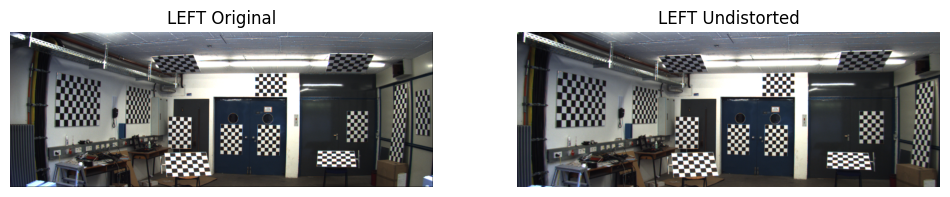

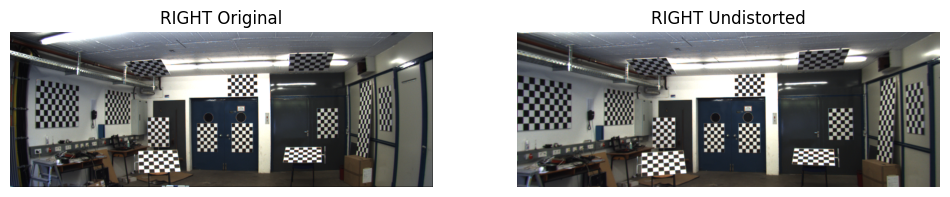

Robust calibration run completed.


In [ ]:
# Cell 2: Example invocation for two cameras (LEFT, RIGHT) and visualization.
# Adjust variable names (cam dict, images_left/right) to match your workspace.

# import random

# If you have constants for camera indices define them (or adapt to your structure)
LEFT = 0
RIGHT = 1

results = {}
for cam_idx, name, img_pool in [
    (LEFT, "LEFT", globals().get("images_left", [])),
    (RIGHT, "RIGHT", globals().get("images_right", [])),
]:
    # pull lists from cam structure - adapt these lines if your structure differs
    obj_list = cam["objpoints"][cam_idx]
    img_list = cam["imgpoints"][cam_idx]
    img_indices_list = cam["image_indices"][cam_idx]

    if len(obj_list) == 0:
        print(f"Skipping {name}: no detections.")
        continue

    image_size = None
    # try to infer image_size from a loaded image or from a previously available 'gray'
    if "gray" in globals():
        image_size = (gray.shape[1], gray.shape[0])
    else:
        # try to get from image pool if available
        if img_pool:
            tmp = cv2.imread(img_pool[0])
            image_size = (tmp.shape[1], tmp.shape[0])
        else:
            # fallback: try to infer from first imgpoints (not ideal but safe)
            # assume points are in pixel coordinates on images of some size; user should supply image_size ideally
            image_size = (1920, 1080)

    res = calibrate_intrinsics_robust(
        obj_list,
        img_list,
        image_size,
        image_indices_list=img_indices_list,
        pre_rejection=False,
        ransac_iterations=200,
        subset_size=6,
        post_rejection=True,
        verbose=True,
        progress=True,
        diversity_subsample=True,
        max_diverse_samples=120,
        min_pose_angle_deg=15.0,
        min_pose_translation=0.1,
        deduplicate=False,
        hash_precision=2,
        enable_stage0=False,
        stage0_min_per_image=3,
        extrinsic_deduplicate=True,
        extrinsic_angle_thresh_deg=4000,
        extrinsic_translation_thresh=0.12,
        extrinsic_keep_per_cluster=2,
        naive_cal_max_samples=50,
        rms_threshold=None,
    )

    cam["K"][cam_idx] = res["K"]
    cam["dist"][cam_idx] = res["dist"]
    results[name] = res

    print(
        f"\n{name} robust calibration summary:\n"
        f"  Total detections         : {res['total_detections']}\n"
        f"  Removed stage0           : {res['removed_stage0']}\n"
        f"  removed_duplicates_geom  : {res['removed_duplicates_geom']}\n"
        f"  removed_duplicates_extr  : {res['removed_duplicates_extr']}\n"
        f"  Diversity selected       : {res['diversity_selected']}\n"
        f"  Removed pre              : {res['removed_pre']}\n"
        f"  Removed post             : {res['removed_post']}\n"
        f"  Final boards             : {res['final_boards']}\n"
        f"  RMS naive                : {res['rms_naive']:.4f} px\n"
        f"  RMS final                : {res['rms_final']:.4f} px\n"
        f"  Improvement (naive-final): {res['rms_naive'] - res['rms_final']:.4f} px\n"
        f"  Runtime                  : {res['runtime_sec']:.2f} s\n"
    )

# Visualization: undistort a random example image per camera
for cam_idx, name, img_pool in [
    (LEFT, "LEFT", globals().get("images_left", [])),
    (RIGHT, "RIGHT", globals().get("images_right", [])),
]:
    Kmat = cam["K"][cam_idx]
    D = cam["dist"][cam_idx]
    if Kmat is None or D is None:
        continue
    if not img_pool:
        continue
    sample = random.choice(img_pool)
    img = cv2.imread(sample)
    if img is None:
        continue
    und = cv2.undistort(img, Kmat, D)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"{name} Original")
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(und, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"{name} Undistorted")
    ax[1].axis("off")
    plt.show()

print("Robust calibration run completed.")


In [94]:
cam["K"][LEFT], cam["dist"][LEFT], cam["K"][RIGHT], cam["dist"][RIGHT]

(array([[1.12452811e+03, 0.00000000e+00, 6.92616774e+02],
        [0.00000000e+00, 1.09454871e+03, 2.55854472e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.15345107, -0.30558533,  0.0007311 , -0.01063352,  0.4432944 ]]),
 array([[966.05544627,   0.        , 703.46612923],
        [  0.        , 968.76650583, 255.96553141],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-4.22379301e-01,  4.43822783e-01,  1.48673723e-04,
         -2.66306662e-03, -3.08911511e-01]]))

## Heatmap Visualization of Final Image Points
Visualize the spatial distribution of final calibration points used in the robust intrinsic calibration.

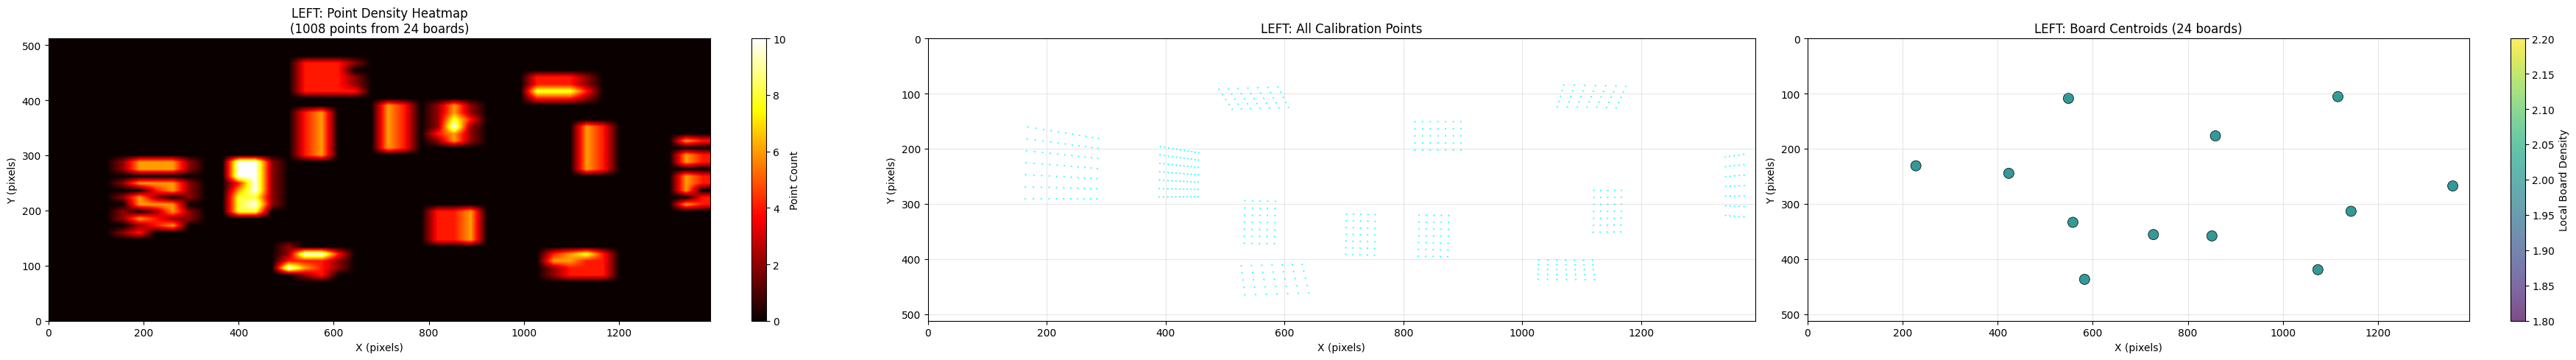


LEFT Coverage Statistics:
  Total points: 1008
  Total boards: 24
  X range: [163.7, 1373.2] (coverage: 86.9%)
  Y range: [84.4, 465.0] (coverage: 74.4%)
  Quadrant distribution (TL/TR/BL/BR): 268/170/250/320


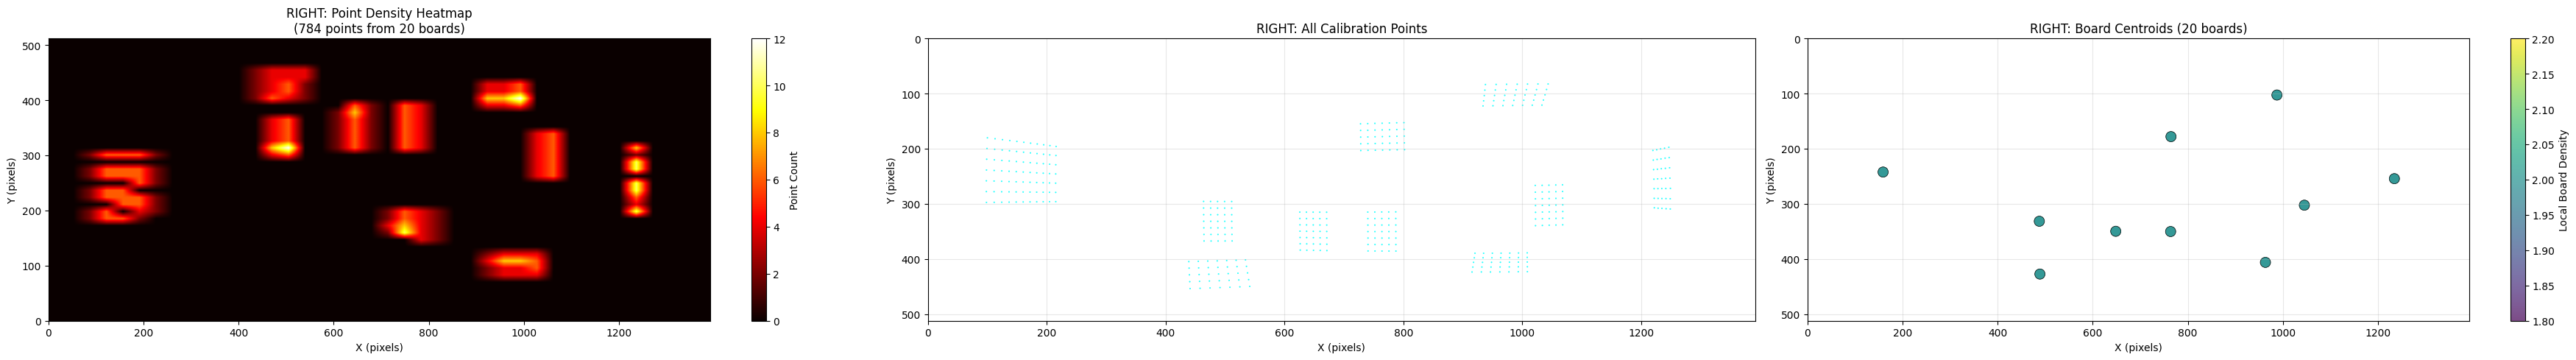


RIGHT Coverage Statistics:
  Total points: 784
  Total boards: 20
  X range: [98.4, 1249.1] (coverage: 82.7%)
  Y range: [82.7, 453.6] (coverage: 72.4%)
  Quadrant distribution (TL/TR/BL/BR): 88/180/276/240


In [95]:
def plot_imagepoints_heatmap(results_dict, image_size, camera_name="Camera", bins=50):
    """
    Create a heatmap showing the spatial distribution of final calibration image points.

    Parameters:
    -----------
    results_dict : dict
        Results dictionary from calibrate_intrinsics_robust containing 'final_imgpoints'
    image_size : tuple
        (width, height) of the image
    camera_name : str
        Name for plot title
    bins : int
        Number of bins for the 2D histogram
    """
    if "final_imgpoints" not in results_dict:
        print(f"No final_imgpoints found in results for {camera_name}")
        return

    final_imgpoints = results_dict["final_imgpoints"]

    # Collect all corner points from all boards
    all_points = []
    for corners in final_imgpoints:
        pts = corners.reshape(-1, 2)
        all_points.append(pts)

    if not all_points:
        print(f"No image points to visualize for {camera_name}")
        return

    all_points = np.vstack(all_points)
    x_coords = all_points[:, 0]
    y_coords = all_points[:, 1]

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(36, 5))

    # 1. Heatmap with 2D histogram
    ax1 = plt.subplot(131)
    h, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=bins, range=[[0, image_size[0]], [0, image_size[1]]])
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    im1 = ax1.imshow(h.T, extent=extent, origin="upper", cmap="hot", aspect="auto", interpolation="bilinear")
    ax1.set_xlabel("X (pixels)")
    ax1.set_ylabel("Y (pixels)")
    ax1.set_title(
        f"{camera_name}: Point Density Heatmap\n({len(all_points)} points from {len(final_imgpoints)} boards)"
    )
    plt.colorbar(im1, ax=ax1, label="Point Count")
    ax1.invert_yaxis()

    # 2. Scatter plot with individual points
    ax2 = plt.subplot(132)
    ax2.scatter(x_coords, y_coords, c="cyan", s=2, alpha=0.6, edgecolors="none")
    ax2.set_xlim(0, image_size[0])
    ax2.set_ylim(image_size[1], 0)
    ax2.set_xlabel("X (pixels)")
    ax2.set_ylabel("Y (pixels)")
    ax2.set_title(f"{camera_name}: All Calibration Points")
    ax2.grid(True, alpha=0.3)

    # 3. Board centroids with color-coded density
    ax3 = plt.subplot(133)
    centroids = np.array([corners.reshape(-1, 2).mean(axis=0) for corners in final_imgpoints])

    # Create 2D histogram for coloring centroids
    h_cent, xe_cent, ye_cent = np.histogram2d(
        centroids[:, 0], centroids[:, 1], bins=20, range=[[0, image_size[0]], [0, image_size[1]]]
    )

    # Assign density values to each centroid
    xi = np.digitize(centroids[:, 0], xe_cent) - 1
    yi = np.digitize(centroids[:, 1], ye_cent) - 1
    xi = np.clip(xi, 0, h_cent.shape[0] - 1)
    yi = np.clip(yi, 0, h_cent.shape[1] - 1)
    density_values = h_cent[xi, yi]

    scatter = ax3.scatter(
        centroids[:, 0],
        centroids[:, 1],
        c=density_values,
        cmap="viridis",
        s=100,
        alpha=0.7,
        edgecolors="black",
        linewidth=0.5,
    )
    ax3.set_xlim(0, image_size[0])
    ax3.set_ylim(image_size[1], 0)
    ax3.set_xlabel("X (pixels)")
    ax3.set_ylabel("Y (pixels)")
    ax3.set_title(f"{camera_name}: Board Centroids ({len(centroids)} boards)")
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label="Local Board Density")

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n{camera_name} Coverage Statistics:")
    print(f"  Total points: {len(all_points)}")
    print(f"  Total boards: {len(final_imgpoints)}")
    print(
        f"  X range: [{x_coords.min():.1f}, {x_coords.max():.1f}] (coverage: {(x_coords.max() - x_coords.min()) / image_size[0] * 100:.1f}%)"
    )
    print(
        f"  Y range: [{y_coords.min():.1f}, {y_coords.max():.1f}] (coverage: {(y_coords.max() - y_coords.min()) / image_size[1] * 100:.1f}%)"
    )

    # Coverage analysis by quadrants
    x_mid, y_mid = image_size[0] / 2, image_size[1] / 2
    q1 = ((x_coords < x_mid) & (y_coords < y_mid)).sum()
    q2 = ((x_coords >= x_mid) & (y_coords < y_mid)).sum()
    q3 = ((x_coords < x_mid) & (y_coords >= y_mid)).sum()
    q4 = ((x_coords >= x_mid) & (y_coords >= y_mid)).sum()
    print(f"  Quadrant distribution (TL/TR/BL/BR): {q1}/{q2}/{q3}/{q4}")


# Generate heatmaps for both cameras
if "results" in globals() and results:
    for name in ["LEFT", "RIGHT"]:
        if name in results:
            plot_imagepoints_heatmap(results[name], image_size, camera_name=name, bins=40)
else:
    print("Run the robust calibration cell first to generate results.")

# Rectification

In [14]:
def _centroid_and_bbox(corners: np.ndarray):
    pts = corners.reshape(-1, 2)
    c = pts.mean(axis=0)  # (x, y)
    _, _, w, h = cv2.boundingRect(corners.astype(np.float32))
    return c, (w, h)


def match_chessboards(
    dets_left,
    dets_right,
    dy_thresh=12.0,
    scale_ratio_thresh=0.25,
    method="greedy",  # 'greedy' or 'hungarian'
):
    """
    Match chessboard detections between left and right images using vertical sorting.

    dets_left/dets_right: list of (corners, (nb_vert, nb_horiz))
    Returns: matches, unmatched_left, unmatched_right

    Modes:
      method='greedy':
        - Group by pattern size
        - Sort both sides by vertical coordinate (y)
        - For each left detection, use binary search to find right candidates within dy_thresh
        - Select best match based on cost = |dy| + 0.3*|dx| + 0.25*|hL-hR|
        - O(N log N) complexity

      method='hungarian':
        - Global optimal assignment using SciPy's Hungarian algorithm
        - Builds full cost matrix with gating constraints
        - O(N^3) but guarantees minimal total cost
        - More robust when greedy ordering fails

    Parameters:
      dy_thresh: vertical gating threshold (pixels) - primary constraint for stereo epipolar geometry
      scale_ratio_thresh: relative height difference threshold for scale consistency
      method: 'greedy' (fast) or 'hungarian' (optimal)
    """
    from bisect import bisect_left, bisect_right

    if method not in {"greedy", "hungarian"}:
        raise ValueError("method must be 'greedy' or 'hungarian'")

    left_groups = defaultdict(list)
    right_groups = defaultdict(list)
    for i, (_, sz) in enumerate(dets_left):
        left_groups[tuple(sz)].append(i)
    for j, (_, sz) in enumerate(dets_right):
        right_groups[tuple(sz)].append(j)

    all_sizes = set(left_groups.keys()) | set(right_groups.keys())

    matches = []
    unmatched_left = []
    unmatched_right = []

    for sz in all_sizes:
        L = left_groups.get(sz, [])
        R = right_groups.get(sz, [])
        if not L:
            unmatched_right.extend(R)
            continue
        if not R:
            unmatched_left.extend(L)
            continue

        # Precompute features
        L_feats = {}
        for i in L:
            c, (w, h) = _centroid_and_bbox(dets_left[i][0])
            L_feats[i] = (c, (w, h))
        R_feats = {}
        for j in R:
            c, (w, h) = _centroid_and_bbox(dets_right[j][0])
            R_feats[j] = (c, (w, h))

        # Sort both sides by vertical coordinate (y)
        L_sorted = sorted(L, key=lambda k: L_feats[k][0][1])
        R_sorted = sorted(R, key=lambda k: R_feats[k][0][1])
        R_y_vals = [R_feats[j][0][1] for j in R_sorted]

        if method == "greedy":
            used_R = set()
            for i in L_sorted:
                cL, (wL, hL) = L_feats[i]
                yL = float(cL[1])
                # Binary search for vertical band
                lo = bisect_left(R_y_vals, yL - dy_thresh)
                hi = bisect_right(R_y_vals, yL + dy_thresh)
                if lo == hi:
                    unmatched_left.append(i)
                    continue

                best_j = None
                best_cost = float("inf")
                for pos in range(lo, hi):
                    j = R_sorted[pos]
                    if j in used_R:
                        continue
                    cR, (wR, hR) = R_feats[j]
                    dy = abs(yL - float(cR[1]))
                    dx = abs(float(cL[0]) - float(cR[0]))

                    # Scale similarity check
                    h_max = max(1.0, float(max(hL, hR)))
                    scale_rel = abs(float(hL) - float(hR)) / h_max
                    if scale_rel > scale_ratio_thresh:
                        continue

                    # Cost: prioritize vertical alignment, consider horizontal disparity and scale
                    cost = dy + 0.3 * dx + 0.25 * abs(float(hL) - float(hR))
                    if cost < best_cost:
                        best_cost = cost
                        best_j = j

                if best_j is not None:
                    matches.append((i, best_j))
                    used_R.add(best_j)
                else:
                    unmatched_left.append(i)
            unmatched_right.extend([j for j in R if j not in used_R])

        else:  # hungarian
            from scipy.optimize import linear_sum_assignment

            nL, nR = len(L_sorted), len(R_sorted)
            # Build cost matrix
            C = np.full((nL, nR), fill_value=1e6, dtype=np.float64)
            for a, i in enumerate(L_sorted):
                cL, (wL, hL) = L_feats[i]
                yL = float(cL[1])
                xL = float(cL[0])
                for b, j in enumerate(R_sorted):
                    cR, (wR, hR) = R_feats[j]
                    yR = float(cR[1])
                    xR = float(cR[0])
                    dy = abs(yL - yR)
                    if dy > dy_thresh:
                        continue
                    dx = abs(xL - xR)
                    h_max = max(1.0, float(max(hL, hR)))
                    scale_rel = abs(float(hL) - float(hR)) / h_max
                    if scale_rel > scale_ratio_thresh:
                        continue
                    cost = dy + 0.3 * dx + 0.25 * abs(float(hL) - float(hR))
                    C[a, b] = cost
            row_ind, col_ind = linear_sum_assignment(C)
            used_R = set()
            for a, b in zip(row_ind, col_ind, strict=False):
                if C[a, b] >= 1e6:
                    continue
                i = L_sorted[a]
                j = R_sorted[b]
                matches.append((i, j))
                used_R.add(j)
            unmatched_left.extend([i for i in L if i not in {m[0] for m in matches}])
            unmatched_right.extend([j for j in R if j not in used_R])

    return matches, unmatched_left, unmatched_right

## Matching Evaluation & Visualization
Compare greedy vs Hungarian methods and visualize matched/unmatched boards with color-coded centroids.

In [15]:
# Quick evaluation helper: compare greedy vertical vs greedy horizontal vs Hungarian
def draw_matched_unmatched_corners(image_pair_index, imgL, imgR, dets_L, dets_R, matches, uL, uR):
    visL = imgL.copy()
    visR = imgR.copy()
    cmap = cm.get_cmap("tab20")

    def centroid(c):
        pts = c.reshape(-1, 2)
        return pts.mean(axis=0)

    # Draw matched centers with consistent colors
    for idx, (iL, iR) in enumerate(matches):
        color = tuple(int(255 * v) for v in cmap(idx % 20)[:3])
        cL = centroid(dets_L[iL][0])
        cR = centroid(dets_R[iR][0])
        cv2.circle(visL, (int(cL[0]), int(cL[1])), 8, color, thickness=2)
        cv2.circle(visR, (int(cR[0]), int(cR[1])), 8, color, thickness=2)
        cv2.putText(
            visL, f"{idx}", (int(cL[0]) + 6, int(cL[1]) - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA
        )
        cv2.putText(
            visR, f"{idx}", (int(cR[0]) + 6, int(cR[1]) - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA
        )

    # Draw unmatched: red on left-only, blue on right-only
    for i in uL:
        c = centroid(dets_L[i][0])
        cv2.circle(visL, (int(c[0]), int(c[1])), 8, (0, 0, 255), thickness=2)
    for j in uR:
        c = centroid(dets_R[j][0])
        cv2.circle(visR, (int(c[0]), int(c[1])), 8, (255, 0, 0), thickness=2)

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].imshow(cv2.cvtColor(visL, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Left k={image_pair_index} — matched={len(matches)} unmatchedL={len(uL)}")
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(visR, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Right k={image_pair_index} — matched={len(matches)} unmatchedR={len(uR)}")
    ax[1].axis("off")
    plt.show()


def evaluate_matching_modes(pair_index=0, dy_thresh=18.0, scale_ratio_thresh=0.25):
    if not len(images_left) or not len(images_right):
        print("No images available.")
        return
    pair_index = int(max(0, min(pair_index, min(len(images_left), len(images_right)) - 1)))
    fnameL, fnameR = images_left[pair_index], images_right[pair_index]
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    if imgL is None or imgR is None:
        print("Could not read images for evaluation.")
        return
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    corners_L, objps_L, sizes_L = find_all_chessboards(grayL, pattern_sizes)
    corners_R, objps_R, sizes_R = find_all_chessboards(grayR, pattern_sizes)
    dets_L = list(zip(corners_L, sizes_L, strict=False))
    dets_R = list(zip(corners_R, sizes_R, strict=False))

    modes = [
        ("greedy-vertical", {"method": "greedy"}),
        ("hungarian", {"method": "hungarian"}),
    ]

    results = []
    for name, kwargs in modes:
        matches, uL, uR = match_chessboards(
            dets_L,
            dets_R,
            dy_thresh=dy_thresh,
            scale_ratio_thresh=scale_ratio_thresh,
            **kwargs,
        )
        draw_matched_unmatched_corners(pair_index, imgL, imgR, dets_L, dets_R, matches, uL, uR)
        # Compute simple stats: average vertical residual among matched centroids
        vert_residuals = []
        horiz_residuals = []
        for iL, iR in matches:
            cL = dets_L[iL][0].reshape(-1, 2).mean(axis=0)
            cR = dets_R[iR][0].reshape(-1, 2).mean(axis=0)
            vert_residuals.append(abs(float(cL[1]) - float(cR[1])))
            horiz_residuals.append(abs(float(cL[0]) - float(cR[0])))
        v_mean = float(np.mean(vert_residuals)) if vert_residuals else float("nan")
        h_mean = float(np.mean(horiz_residuals)) if horiz_residuals else float("nan")
        results.append((name, len(matches), len(uL), len(uR), v_mean, h_mean))

    # Print summary
    print("Matching mode comparison (pair_index=%d):" % pair_index)
    for name, m_cnt, uL_cnt, uR_cnt, v_mean, h_mean in results:
        print(
            f"  {name:<18} matches={m_cnt:3d} unmL={uL_cnt:2d} unmR={uR_cnt:2d} "
            f"mean|dy|={v_mean:6.2f} mean|dx|={h_mean:6.2f}"
        )


# Example evaluation call (adjust pair_index as needed):
# evaluate_matching_modes(0, dy_thresh=18.0, scale_ratio_thresh=0.25)

## Stereo Pair Matching & Data Collection
Process all image pairs, detect chessboards, match left-right boards, and build stereo calibration dataset.

In [16]:
# Detect per stereo pair and build matched stereo sets
square_size = 0.1  # meters (or any consistent unit)

stereo = {
    "objpoints": [],
    "imgpoints_left": [],
    "imgpoints_right": [],
}

pair_count = min(len(images_left), len(images_right))
print(f"Processing {pair_count} stereo pairs for matching…")

for image_pair_index in range(pair_count):
    fnameL, fnameR = images_left[image_pair_index], images_right[image_pair_index]
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    if imgL is None or imgR is None:
        print(f"Skipping pair {image_pair_index}: read error")
        continue
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Run multi-board detection on each side
    corners_L, objps_L, sizes_L = find_all_chessboards(grayL, pattern_sizes)
    corners_R, objps_R, sizes_R = find_all_chessboards(grayR, pattern_sizes)

    # Pack detections as (corners, (nb_vert, nb_horiz))
    dets_L = list(zip(corners_L, sizes_L, strict=False))
    dets_R = list(zip(corners_R, sizes_R, strict=False))

    matches, uL, uR = match_chessboards(dets_L, dets_R, method="hungarian", dy_thresh=18.0, scale_ratio_thresh=0.25)

    # Build stereo lists from matches
    matched_this_pair = 0
    for iL, iR in matches:
        cornersL, size = dets_L[iL]
        cornersR, sizeR = dets_R[iR]
        # Plausibility: pattern sizes must agree exactly
        if tuple(size) != tuple(sizeR):
            continue
        nb_vert, nb_horiz = size
        # Sanity check on counts
        if cornersL.shape[0] != nb_vert * nb_horiz:
            continue
        if cornersR.shape[0] != nb_vert * nb_horiz:
            continue

        objp = np.zeros((nb_horiz * nb_vert, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nb_vert, 0:nb_horiz].T.reshape(-1, 2)
        objp *= float(square_size)

        # Ensure dtype and shape are compatible with OpenCV
        cornersL = cornersL.astype(np.float32, copy=False)
        cornersR = cornersR.astype(np.float32, copy=False)

        stereo["objpoints"].append(objp)
        stereo["imgpoints_left"].append(cornersL)
        stereo["imgpoints_right"].append(cornersR)
        matched_this_pair += 1

    print(
        f"Pair {image_pair_index}: left={len(dets_L)} right={len(dets_R)} matched={matched_this_pair} (unmatched L={len(uL)}, R={len(uR)})"
    )

print(f"Total matched boards: {len(stereo['objpoints'])} across {pair_count} pairs")

Processing 19 stereo pairs for matching…
Pair 0: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 0: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 1: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 1: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 2: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 2: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 3: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 3: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 4: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 4: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 5: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 5: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 6: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 6: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 7: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 7: left=13 right=11 matched=11 (unmatched L=2, R=0)
Pair 8: left=13 right=11 matched=11 (unmatched 

## Stereo Calibration & Rectification
Compute extrinsic parameters (R, T) and generate rectification maps for epipolar-aligned stereo.

In [17]:
# Stereo calibration using matched boards (fix intrinsics if already calibrated)
if cam["K"][LEFT] is None or cam["K"][RIGHT] is None:
    assert "Calculate intrinsics first."
else:
    # Infer image size from a sample
    img0 = cv2.imread(images_left[0])
    image_size = (img0.shape[1], img0.shape[0])

criteria_stereo = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
flags = cv2.CALIB_FIX_INTRINSIC if cam["K"][LEFT] is not None and cam["K"][RIGHT] is not None else 0

rms, K1, d1, K2, d2, R, T, E, F = cv2.stereoCalibrate(
    stereo["objpoints"],
    stereo["imgpoints_left"],
    stereo["imgpoints_right"],
    cam["K"][LEFT],
    cam["dist"][LEFT],
    cam["K"][RIGHT],
    cam["dist"][RIGHT],
    image_size,
    criteria=criteria_stereo,
    flags=flags,
)

# cam["K"][LEFT], cam["dist"][LEFT] = K1, d1
# cam["K"][RIGHT], cam["dist"][RIGHT] = K2, d2

print(f"Stereo RMS reprojection error: {rms:.4f}")

# Rectification and undistort-rectify maps
# alpha=-1 lets OpenCV choose a default scaling between 0 (crop) and 1 (full)
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cam["K"][LEFT],
    cam["dist"][LEFT],
    cam["K"][RIGHT],
    cam["dist"][RIGHT],
    image_size,
    R,
    T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=0.2,
)
cam["R"][LEFT], cam["R"][RIGHT] = R1, R2
cam["P"][LEFT], cam["P"][RIGHT] = P1, P2
cam["Q"] = Q
cam["roi"] = [roi1, roi2]  # Store valid ROIs for visualization

cam["map1"][LEFT], cam["map2"][LEFT] = cv2.initUndistortRectifyMap(
    cam["K"][LEFT], cam["dist"][LEFT], R1, P1, image_size, cv2.CV_16SC2
)
cam["map1"][RIGHT], cam["map2"][RIGHT] = cv2.initUndistortRectifyMap(
    cam["K"][RIGHT], cam["dist"][RIGHT], R2, P2, image_size, cv2.CV_16SC2
)

print(f"Rectification maps computed. Valid ROIs: L={roi1}, R={roi2}")

Stereo RMS reprojection error: 6.8349
Rectification maps computed. Valid ROIs: L=(0, 0, 0, 0), R=(0, 0, 0, 0)


## ⚠️ Undistort Sample Images (OLD METHOD)
**POTENTIALLY IRRELEVANT**: Uses old `newcameramtx` instead of rectification maps. For stereo work, use rectified outputs below.

In [ ]:
# Undistort LEFT sample
# dst_left = cv2.undistort(
#     img_left,
#     cam["K"][LEFT],
#     cam["dist"][LEFT],
#     None,
#     newcameramtx_left,
# )

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# ax[0].imshow(img_left[..., ::-1])
# ax[0].set_title("Left Original")
# ax[1].imshow(dst_left[..., ::-1])
# ax[1].set_title("Left Undistorted")

NameError: name 'img_left' is not defined

Text(0.5, 1.0, 'Right Undistorted')

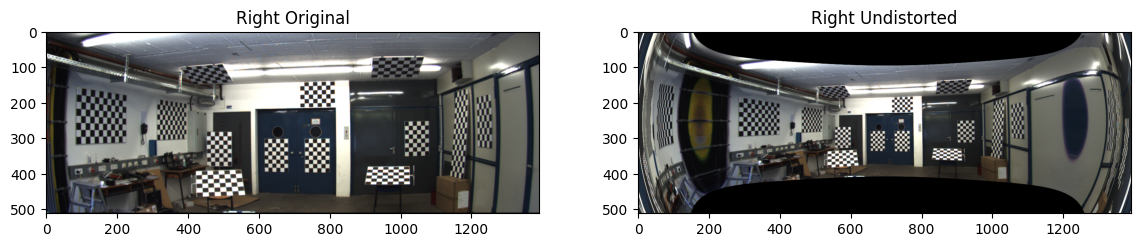

In [ ]:
# Undistort RIGHT sample
# dst_right = cv2.undistort(img_right, cam["K"][RIGHT], cam["dist"][RIGHT], None, newcameramtx_right)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# ax[0].imshow(img_right[..., ::-1])
# ax[0].set_title("Right Original")
# ax[1].imshow(dst_right[..., ::-1])
# ax[1].set_title("Right Undistorted")

## Interactive Match Visualization
Visualize matched (colored) and unmatched (red/blue) chessboard centroids for a specific stereo pair.

In [ ]:
# Visualization: matched/unmatched chessboard centers for a chosen pair
def visualize_matches_for_pair(image_pair_index=0, dy_thresh=8.0, scale_ratio_thresh=0.25):
    if not len(images_left) or not len(images_right):
        print("No images available.")
        return
    image_pair_index = int(max(0, min(image_pair_index, min(len(images_left), len(images_right)) - 1)))
    fnameL, fnameR = images_left[image_pair_index], images_right[image_pair_index]
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    if imgL is None or imgR is None:
        print("Could not read images for visualization.")
        return
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    corners_L, objps_L, sizes_L = find_all_chessboards(grayL, pattern_sizes)
    corners_R, objps_R, sizes_R = find_all_chessboards(grayR, pattern_sizes)

    dets_L = list(zip(corners_L, sizes_L, strict=False))
    dets_R = list(zip(corners_R, sizes_R, strict=False))

    matches, uL, uR = match_chessboards(
        dets_L, dets_R, method="hungarian", dy_thresh=dy_thresh, scale_ratio_thresh=scale_ratio_thresh
    )

    # Prepare drawing
    draw_matched_unmatched_corners(image_pair_index, imgL, imgR, dets_L, dets_R, matches, uL, uR)


# Example usage:
# visualize_matches_for_pair(0, dy_thresh=18.0, scale_ratio_thresh=0.25)

## Rectification Quality Check
Visualize rectified stereo pair with horizontal guide lines to verify epipolar alignment (points should lie on same scan lines).

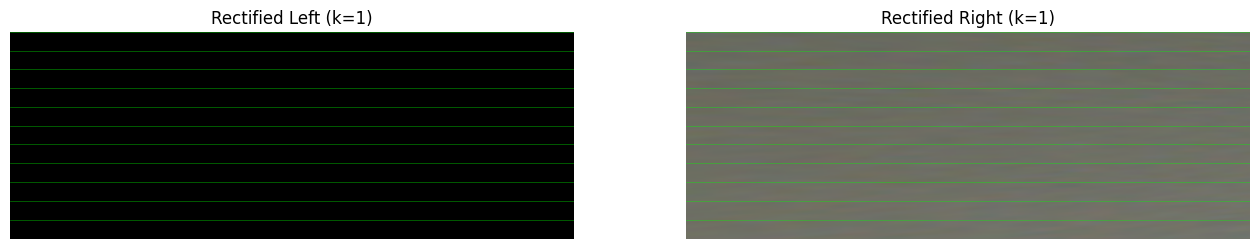

In [20]:
# Visualization: rectification preview with horizontal guides


def preview_rectification(k=0, n_guides=10):
    # Ensure maps are available
    if cam["map1"][LEFT] is None or cam["map1"][RIGHT] is None:
        print("Rectification maps not available. Run stereo calibration cell first.")
        return
    if not len(images_left) or not len(images_right):
        print("No images available.")
        return

    k = int(max(0, min(k, min(len(images_left), len(images_right)) - 1)))
    imgL = cv2.imread(images_left[k])
    imgR = cv2.imread(images_right[k])
    if imgL is None or imgR is None:
        print("Could not read images for rectification preview.")
        return

    # Remap
    rectL = cv2.remap(imgL, cam["map1"][LEFT], cam["map2"][LEFT], interpolation=cv2.INTER_LINEAR)
    rectR = cv2.remap(imgR, cam["map1"][RIGHT], cam["map2"][RIGHT], interpolation=cv2.INTER_LINEAR)

    h, w = rectL.shape[:2]
    ys = np.linspace(0, h - 1, num=max(2, n_guides), dtype=int)

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].imshow(cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Rectified Left (k={k})")
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Rectified Right (k={k})")
    ax[1].axis("off")

    # Draw horizontal guide lines
    for y in ys:
        ax[0].axhline(y=y, color="lime", linewidth=0.5, alpha=0.5)
        ax[1].axhline(y=y, color="lime", linewidth=0.5, alpha=0.5)

    # Draw valid ROI rectangles if available
    if "roi" in cam:
        import matplotlib.patches as patches

        for i, roi in enumerate(cam["roi"]):
            x, y, w_roi, h_roi = roi
            # Create a Rectangle patch
            rect = patches.Rectangle(
                (x, y), w_roi, h_roi, linewidth=2, edgecolor="red", facecolor="none", label="Valid ROI"
            )
            ax[i].add_patch(rect)

    plt.show()


# Example usage:
preview_rectification(1, n_guides=12)

In [ ]:
cam["R"][LEFT], cam["R"][RIGHT], cam["P"][LEFT], cam["P"][RIGHT]

(array([[ 0.73313063,  0.03028306, -0.67941329],
        [-0.03357982,  0.99940148,  0.0083109 ],
        [ 0.67925833,  0.0167216 ,  0.73370874]]),
 array([[ 0.72821002,  0.01510291, -0.68518762],
        [-0.01177285,  0.99988531,  0.00952741],
        [ 0.68525292,  0.00112866,  0.7283043 ]]),
 array([[-1.82609701e+02,  0.00000000e+00,  3.15605496e+03,
          0.00000000e+00],
        [ 0.00000000e+00, -1.82609701e+02,  2.51354740e+02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00]]),
 array([[-1.82609701e+02,  0.00000000e+00,  3.15605496e+03,
          1.49727341e+02],
        [ 0.00000000e+00, -1.82609701e+02,  2.51354740e+02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00]]))

In [ ]:
for a in [0.0, 0.25, 0.5, 0.75, 1.0]:
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cam["K"][LEFT],
        cam["dist"][LEFT],
        cam["K"][RIGHT],
        cam["dist"][RIGHT],
        image_size,
        R,
        T,
        flags=cv2.CALIB_ZERO_DISPARITY,
        alpha=a,
    )
    print(
        f"alpha={a}: P1 fx={P1[0, 0]:.2f} fy={P1[1, 1]:.2f} cx={P1[0, 2]:.2f} cy={P1[1, 2]:.2f} ROI_L={roi1} ROI_R={roi2}"
    )

alpha=0.0: P1 fx=13362.03 fy=13362.03 cx=3156.05 cy=251.35 ROI_L=(0, 0, 0, 0) ROI_R=(0, 0, 0, 0)
alpha=0.25: P1 fx=9941.67 fy=9941.67 cx=3156.05 cy=251.35 ROI_L=(0, 0, 0, 0) ROI_R=(0, 0, 0, 0)
alpha=0.5: P1 fx=6521.31 fy=6521.31 cx=3156.05 cy=251.35 ROI_L=(0, 0, 0, 0) ROI_R=(0, 0, 0, 0)
alpha=0.75: P1 fx=3100.94 fy=3100.94 cx=3156.05 cy=251.35 ROI_L=(0, 0, 0, 0) ROI_R=(0, 0, 0, 0)
alpha=1.0: P1 fx=-319.42 fy=-319.42 cx=3156.05 cy=251.35 ROI_L=(0, 0, 0, 0) ROI_R=(0, 0, 0, 0)


In [ ]:
U, S, Vt = np.linalg.svd(E)
print("E singular values:", S, "ratio S0/S1:", S[0] / S[1], "S2:", S[2])

E singular values: [8.19930923e-01 8.19930923e-01 1.08362944e-16] ratio S0/S1: 1.0000000000000002 S2: 1.0836294381473146e-16


In [ ]:
baseline = np.linalg.norm(T)
print("Baseline (meters?) =", baseline)
print("Normalized direction:", T / (baseline + 1e-12))

Baseline (meters?) = 0.8199309234653779
Normalized direction: [[-0.72821002]
 [-0.01510291]
 [ 0.68518762]]


In [ ]:
def epipolar_y_residual(use_matches=True):
    if "R1" not in globals() or "R2" not in globals() or "P1" not in globals() or "P2" not in globals():
        print("Rectification matrices R1/R2 or projection matrices P1/P2 missing.")
        return
    errs = []
    pairs = []
    # Prefer matched board indices if available
    if use_matches and "matches" in globals() and matches:
        for iL, iR in matches:
            if iL < len(corners_L) and iR < len(corners_R):
                pairs.append((corners_L[iL], corners_R[iR]))
    else:
        n = min(len(corners_L), len(corners_R))
        for i in range(n):
            pairs.append((corners_L[i], corners_R[i]))
    if not pairs:
        print("No corner pairs for epipolar residual.")
        return
    for cL, cR in pairs:
        ptsL = cv2.undistortPoints(cL.reshape(-1, 1, 2), cam["K"][LEFT], cam["dist"][LEFT], R=R1, P=P1).reshape(-1, 2)
        ptsR = cv2.undistortPoints(cR.reshape(-1, 1, 2), cam["K"][RIGHT], cam["dist"][RIGHT], R=R2, P=P2).reshape(-1, 2)
        m = min(len(ptsL), len(ptsR))
        if m == 0:
            continue
        dy = np.abs(ptsL[:m, 1] - ptsR[:m, 1])
        errs.extend(dy.tolist())
    if not errs:
        print("No epipolar residuals computed.")
        return
    errs = np.array(errs)
    print(f"Epipolar y residual: mean={errs.mean():.3f} px, max={errs.max():.3f} px, N={len(errs)}")


# Run diagnostic
epipolar_y_residual()

Epipolar y residual: mean=0.523 px, max=2.602 px, N=469


In [ ]:
def fundamental_error(F, ptsL, ptsR):
    # pts as Nx2
    ptsLh = np.hstack([ptsL, np.ones((ptsL.shape[0], 1))])
    ptsRh = np.hstack([ptsR, np.ones((ptsR.shape[0], 1))])
    # x'Fx form
    errs = []
    for xL, xR in zip(ptsLh, ptsRh):
        val = xR @ F @ xL
        # normalize by epipolar line magnitude
        lR = F @ xL
        lL = F.T @ xR
        eR = abs(val) / np.sqrt(lR[0] ** 2 + lR[1] ** 2)
        eL = abs(val) / np.sqrt(lL[0] ** 2 + lL[1] ** 2)
        errs.append((eR + eL) / 2.0)
    return np.array(errs)


# Example (use raw distorted chessboard detections):
errs = fundamental_error(F, cornersL.reshape(-1, 2), cornersR.reshape(-1, 2))
print("Fundamental avg error:", errs.mean(), "max:", errs.max())

Fundamental avg error: 1.0271475200393902 max: 2.106975215721648


In [ ]:
undL = cv2.undistort(imgL, cam["K"][LEFT], cam["dist"][LEFT])
undR = cv2.undistort(imgR, cam["K"][RIGHT], cam["dist"][RIGHT])
rectL = cv2.remap(imgL, cam["map1"][LEFT], cam["map2"][LEFT], cv2.INTER_LINEAR)
rectR = cv2.remap(imgR, cam["map1"][RIGHT], cam["map2"][RIGHT], cv2.INTER_LINEAR)
# show side-by-side